# Capstone Project - Coursera

In [1]:
# This notebook contains the code of the project described in the report.
# Essentially, the code in this notebook determines which neighborhood of those in Toronto, Montreal, Vancouver, Edmonton
# and Calgary (Canada's five largest cities by population), optimally satisfies the venue preferences of a fictional family.

In [2]:
# libraries
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

### Retrieving data

##### Scraping Wikipedia for postal codes and neighborhood names, getting geodata from geonames.org

In [5]:
# Postal codes and their latitude/longitude from geonames.org
headers = ["Country","PostalCode","Neighborhood","Province","Province code","NaN","zero","Borough?","Borough code?","latitude","longitude","some code"]
geo_data = pd.read_csv(r"CA.txt", sep="\t", names = headers)

In [6]:
# Toronto postal codes and neighborhoods
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(source, 'html5lib')

columns = ['PostalCode', 'Borough', 'Neighborhood']
toronto_data = pd.DataFrame(columns=columns)

for table_cell in soup.find_all('tr'):

    y = table_cell.text.replace('\n',',').split(',')
    
    try:
        if len(y[1]) == 3:
            toronto_data.loc[soup.find_all('tr').index(table_cell)] = y[1:4]
        
        else:
            pass
        
    except:
        pass
        
toronto_data = toronto_data.loc[toronto_data["Borough"] != "Not assigned"].drop_duplicates(subset="PostalCode").reset_index(drop=True)
toronto_data["Neighborhood"] = np.where(toronto_data["Neighborhood"]=="Not assigned", toronto_data["Borough"],toronto_data["Neighborhood"])
print(toronto_data.shape)
toronto_data.head()

(103, 3)


,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M7A,Queen's Park,Queen's Park


In [7]:
# Montreal postal codes and neighborhoods
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_H').text
soup = BeautifulSoup(source, 'html5lib')

columns = ['PostalCode', 'Borough', 'Neighborhood']
Montreal_data = pd.DataFrame(columns=columns)

for table_cell in soup.find_all('td'):
    
    try:
        y = [table_cell.p.b.text,table_cell.p.a.text,table_cell.p.span.text]
        if len(y[0]) == 3:
            Montreal_data.loc[soup.find_all('td').index(table_cell)] = y
        
        else:
            pass
        
    except:
        pass
        
Montreal_data = Montreal_data.drop_duplicates(subset="PostalCode").reset_index(drop=True)
print(Montreal_data.shape)
Montreal_data.head()

(123, 3)


,PostalCode,Borough,Neighborhood
0,H1A,Pointe-aux-Trembles,Pointe-aux-Trembles
1,H2A,Saint-Michel,Saint-MichelEast
2,H3A,Downtown Montreal,Downtown MontrealNorth(McGill University)
3,H4A,Notre-Dame-de-Grâce,Notre-Dame-de-GrâceNortheast
4,H5A,Place Bonaventure,Place Bonaventure


In [8]:
# Vancouver postal codes and neighborhoods
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_V').text
soup = BeautifulSoup(source, 'html5lib')

columns = ['PostalCode', 'Borough', 'Neighborhood']
Vancouver_data = pd.DataFrame(columns=columns)

for table_cell in soup.find_all('td'):
    
    try:
        y = [table_cell.b.text,table_cell.a.text,table_cell.span.text]
        if len(y[0]) == 3:
            Vancouver_data.loc[soup.find_all('td').index(table_cell)] = y
        
        else:
            pass
        
    except:
        pass
    
Vancouver_data = Vancouver_data.drop_duplicates(subset="PostalCode").reset_index(drop=True)

# Postal codes that start with V0 are rural codes and need to be excluded
Vancouver_data = Vancouver_data.loc[Vancouver_data["PostalCode"].str[0:2] != "V0"].reset_index(drop=True)

print(Vancouver_data.shape)
Vancouver_data.head()

(174, 3)


,PostalCode,Borough,Neighborhood
0,V1A,Kimberley,Kimberley
1,V2A,Penticton,Penticton
2,V3A,Langley Township,Langley Township(Langley City)
3,V4A,Surrey,SurreySouthwest
4,V5A,Burnaby,Burnaby(Government Road / Lake City / SFU / Bu...


In [9]:
# Edmonton and Calgary postal codes and neighborhoods
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_T').text
soup = BeautifulSoup(source, 'html5lib')

columns = ['PostalCode', 'Borough', 'Neighborhood']
EDandCAL_data = pd.DataFrame(columns=columns)

for table_cell in soup.find_all('td'):
    
    try:
        y = [table_cell.b.text,table_cell.a.text,table_cell.span.text]
        if len(y[0]) == 3:
            EDandCAL_data.loc[soup.find_all('td').index(table_cell)] = y
        
        else:
            pass
        
    except:
        pass
    
EDandCAL_data = EDandCAL_data.drop_duplicates(subset="PostalCode").reset_index(drop=True)

# Postal codes that start with T0 are rural codes and need to be excluded
EDandCAL_data = EDandCAL_data.loc[EDandCAL_data["PostalCode"].str[0:2] != "T0"].reset_index(drop=True)

print(EDandCAL_data.shape)
EDandCAL_data.head()

(142, 3)


,PostalCode,Borough,Neighborhood
0,T1A,Medicine Hat,Medicine HatCentral
1,T2A,Calgary,Calgary(Penbrooke Meadows / Marlborough)
2,T3A,Calgary,Calgary(Dalhousie / Edgemont / Hamptons / Hidd...
3,T4A,Airdrie,AirdrieEast
4,T5A,Edmonton,Edmonton(West Clareview / East Londonderry)


In [10]:
# The Wikipages for Toronto as well as Montreal list the postal codes of neighborhoods in the respective city.
# The pages of the other three chosen cities list the ones of the entire province.
# Therefore, Toronto and Montreal are not further specified than done above. (Unless I misunderstood something)

Vancouver_data = Vancouver_data.loc[Vancouver_data["Borough"].str.contains('Vancouver')]
Edmonton_data = EDandCAL_data.loc[EDandCAL_data["Borough"].str.contains('Edmonton')]
Calgary_data = EDandCAL_data.loc[EDandCAL_data["Borough"].str.contains('Calgary')]
print(toronto_data.shape[0], Montreal_data.shape[0], Vancouver_data.shape[0], Edmonton_data.shape[0], Calgary_data.shape[0])

103 123 44 38 35


In [11]:
# Adding city names to dataframes
toronto_data["City"] = "Toronto"
Montreal_data["City"] = "Montreal"
Vancouver_data["City"] = "Vancouver"
Edmonton_data["City"] = "Edmonton"
Calgary_data["City"] = "Calgary"

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [12]:
# Looking at the geodata imported further above
geo_data.head()

,Country,PostalCode,Neighborhood,Province,Province code,NaN,zero,Borough?,Borough code?,latitude,longitude,some code
0,CA,T0A,Eastern Alberta (St. Paul),Alberta,AB,NaN,NaN,NaN,NaN,54.7660,-111.7174,6.0
1,CA,T0B,Wainwright Region (Tofield),Alberta,AB,NaN,NaN,NaN,NaN,53.0727,-111.5816,6.0
2,CA,T0C,Central Alberta (Stettler),Alberta,AB,NaN,NaN,NaN,NaN,52.1431,-111.6941,5.0
3,CA,T0E,Western Alberta (Jasper),Alberta,AB,NaN,NaN,NaN,NaN,53.6758,-115.0948,5.0
4,CA,T0G,North Central Alberta (Slave Lake),Alberta,AB,NaN,NaN,NaN,NaN,55.6993,-114.4529,6.0


In [13]:
# There are a few duplicate postal codes in the data
print(geo_data.shape,geo_data.drop_duplicates(subset="PostalCode").shape)

geo_data = geo_data.drop_duplicates(subset="PostalCode")

(1653, 12) (1649, 12)


In [14]:
# Merging to assign latitude and longitude to neighborhoods
toronto_data = toronto_data.merge(geo_data[["PostalCode","latitude","longitude"]], how="left",on="PostalCode")
Montreal_data = Montreal_data.merge(geo_data[["PostalCode","latitude","longitude"]], how="left",on="PostalCode")
Vancouver_data = Vancouver_data.merge(geo_data[["PostalCode","latitude","longitude"]], how="left",on="PostalCode")
Edmonton_data = Edmonton_data.merge(geo_data[["PostalCode","latitude","longitude"]], how="left",on="PostalCode")
Calgary_data = Calgary_data.merge(geo_data[["PostalCode","latitude","longitude"]], how="left",on="PostalCode")

In [15]:
# Checking of there are any neighborhoods without lat / long
print(toronto_data.loc[toronto_data["latitude"].isnull()].shape[0],
      Montreal_data.loc[Montreal_data["latitude"].isnull()].shape[0],
      Vancouver_data.loc[Vancouver_data["latitude"].isnull()].shape[0],
      Edmonton_data.loc[Edmonton_data["latitude"].isnull()].shape[0],
      Calgary_data.loc[Calgary_data["latitude"].isnull()].shape[0])

1 0 0 0 0


In [16]:
# 1 is missing in Toronto.. it doesn't seem very important though.
toronto_data.loc[toronto_data["latitude"].isnull()]

,PostalCode,Borough,Neighborhood,City,latitude,longitude
76,M7R,Mississauga,Canada Post Gateway Processing Centre,Toronto,NaN,NaN


In [17]:
toronto_data = toronto_data.loc[toronto_data["latitude"].notnull()]

In [18]:
# Combining the datasets to a final large one
frames = [toronto_data, Montreal_data, Vancouver_data, Edmonton_data, Calgary_data]
Dataset = pd.concat(frames).reset_index(drop=True)

# Many of the scraped neighborhoods contain the city name - I couldn't get a more efficient code to work..
Dataset["Neighborhood"] = Dataset["Neighborhood"].str.replace("Edmonton","")
Dataset["Neighborhood"] = Dataset["Neighborhood"].str.replace("Calgary","")
Dataset["Neighborhood"] = Dataset["Neighborhood"].str.replace("Montreal","")
Dataset["Neighborhood"] = Dataset["Neighborhood"].str.replace("Montréal","")
Dataset["Neighborhood"] = Dataset["Neighborhood"].str.replace("Vancouver","")
Dataset["Neighborhood"] = Dataset["Neighborhood"].str.replace("(","")
Dataset["Neighborhood"] = Dataset["Neighborhood"].str.replace(")","")


Dataset.head()

,PostalCode,Borough,Neighborhood,City,latitude,longitude
0,M3A,North York,Parkwoods,Toronto,43.7545,-79.3300
1,M4A,North York,Victoria Village,Toronto,43.7276,-79.3148
2,M5A,Downtown Toronto,Harbourfront,Toronto,43.6555,-79.3626
3,M6A,North York,Lawrence Heights,Toronto,43.7223,-79.4504
4,M7A,Queen's Park,Queen's Park,Toronto,43.6641,-79.3889


In [19]:
# check if any Neighborhoods are duplicated - there is 1
print(Dataset[["Neighborhood"]].shape[0], Dataset[["Neighborhood"]].drop_duplicates().shape[0])

342 341


In [20]:
# find the duplicates
Dataset[Dataset.Neighborhood.duplicated(keep=False)]

,PostalCode,Borough,Neighborhood,City,latitude,longitude
93,M9W,Etobicoke,Northwest,Toronto,43.7144,-79.5909
332,T3R,Calgary,Northwest,Calgary,51.2021,-114.2453


In [21]:
# replace the Neighborhood
for i in range(Dataset.shape[0]):
    
    if Dataset.loc[Dataset["Neighborhood"] == Dataset.loc[i,"Neighborhood"]].shape[0] >1:
        Dataset.loc[i,"Neighborhood"] = Dataset.loc[i,"Neighborhood"] + "-"+Dataset.loc[i,"City"]

In [22]:
# check if code worked
Dataset.loc[93]

PostalCode                    M9W
Borough                 Etobicoke
Neighborhood    Northwest-Toronto
City                      Toronto
latitude                  43.7144
longitude                -79.5909
Name: 93, dtype: object

### Folium

In [23]:
# starting the view with an overview
address = 'Canada'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Canada are {}, {}.'.format(latitude, longitude))

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  after removing the cwd from sys.path.


The geograpical coordinates of Canada are 61.0666922, -107.9917071.


In [24]:
# create map of Dataset using latitude and longitude values
map_data = folium.Map(location=[latitude, longitude], zoom_start=4)

# add markers to map
for lat, lng, label in zip(Dataset['latitude'], Dataset['longitude'], Dataset['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        htm_parser=False).add_to(map_data)
    
map_data

### Foursquare API

In [25]:
#### Foursquare
CLIENT_ID = 'VSTNRZEUP41KY4H3LDKDENA2YJCXCOQNHAA0WSSGCBVOUEVA' # your Foursquare ID
CLIENT_SECRET = 'GQH240J0BWK4JIKYCUJNEV1AWKAMRFKIW0MJYEB51YVTUPFT' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: VSTNRZEUP41KY4H3LDKDENA2YJCXCOQNHAA0WSSGCBVOUEVA
CLIENT_SECRET:GQH240J0BWK4JIKYCUJNEV1AWKAMRFKIW0MJYEB51YVTUPFT


In [26]:
# Analysis will be limited to the top 100 venues, 750m neighborhood radius
LIMIT = 100
radius = 750


In [27]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [28]:
def getNearbyVenues(names, latitudes, longitudes, radius=750):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [31]:
Dataset_venues = getNearbyVenues(names=Dataset['Neighborhood'],
                                   latitudes=Dataset['latitude'],
                                   longitudes=Dataset['longitude']
                                  )

Parkwoods
Victoria Village
Harbourfront
Lawrence Heights
Queen's Park
Islington Avenue
Rouge
Don Mills North
Woodbine Gardens
Ryerson
Glencairn
Cloverdale
Highland Creek
Flemingdon Park
Woodbine Heights
St. James Town
Humewood-Cedarvale
Bloordale Gardens
Guildwood
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor
Thorncliffe Park
Adelaide
Dovercourt Village
Scarborough Village
Fairview
Northwood Park
East Toronto
Harbourfront East
Little Portugal
East Birchmount Park
Bayview Village
CFB Toronto
The Danforth West
Design Exchange
Brockton
Clairlea
Silver Hills
Downsview West
The Beaches West
Commerce Court
Maple Leaf Park
Humber Summit
Cliffcrest
Newtonbrook
Downsview Central
Studio District
Bedford Park
Del Ray
Emery
Birch Cliff
Willowdale South
Downsview Northwest
Lawrence Park
Roselawn
The Junction North
Weston
Dorset Park
York Mills West
Davisville North
Forest Hill North
High Park
Westmount
Maryvale
Will

In [32]:
Dataset_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.7545,-79.33,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant
1,Parkwoods,43.7545,-79.33,Brookbanks Park,43.751976,-79.332140,Park
2,Parkwoods,43.7545,-79.33,Tim Hortons,43.760668,-79.326368,Café
3,Parkwoods,43.7545,-79.33,A&W Canada,43.760643,-79.326865,Fast Food Restaurant
4,Parkwoods,43.7545,-79.33,Pizza Pizza,43.760231,-79.325666,Pizza Place


In [33]:
# one hot encoding
Dataset_onehot = pd.get_dummies(Dataset_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Dataset_onehot['Neighbourhood'] = Dataset_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [Dataset_onehot.columns[-1]] + list(Dataset_onehot.columns[:-1])
Dataset_onehot = Dataset_onehot[fixed_columns]

Dataset_onehot.head()

,Neighbourhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Terminal,American Restaurant,Animal Shelter,...,Vietnamese Restaurant,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
Dataset_onehot.shape

(9289, 409)

In [35]:
# Frequencies of venues
Dataset_grouped = Dataset_onehot.groupby('Neighbourhood').sum().reset_index()
Dataset_grouped.head()

,Neighbourhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Terminal,American Restaurant,Animal Shelter,...,Vietnamese Restaurant,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,East,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Laval-sur-le-Lac,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,West,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-NordNorth,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-NordSouth,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [36]:
# venues list (partly)
list(Dataset_grouped)[0:10]

['Neighbourhood',
 'ATM',
 'Accessories Store',
 'Adult Boutique',
 'Afghan Restaurant',
 'African Restaurant',
 'Airport',
 'Airport Terminal',
 'American Restaurant',
 'Animal Shelter']

In [37]:
# a little gimmick if you want to randomize the preferences
def random_pref():
    a = list(Dataset_grouped.columns.values[1:])[np.round(Dataset_grouped.shape[1]*np.random.rand()).astype(int)]
    return a

In [38]:
# dataframe with the family members' preferences
columns = ['Priority-Parents', 'Mom', 'Dad', 'Priority-Kids','Son', 'Daughter']
Family_wishes = pd.DataFrame(columns=columns)

### randomized preferences On-Off switch
randomized = 0 # 1 = on and 0 = off
###

if randomized == 0:

    Family_wishes.loc[0] = [40, 'Yoga Studio', 'Golf Course', 50, 'Hockey Arena','Recreation Center']
    Family_wishes.loc[1] = [30, 'Café', 'Bagel Shop', 40, 'Nightclub','Accessories Store']
    Family_wishes.loc[2] = [20, 'Museum', 'Karaoke Bar', 30, 'Bar','Movie Theater']
    Family_wishes.loc[3] = [10, 'Jewelry Store', 'Wine Bar', 20, 'Comedy Club','Shopping Mall']
    Family_wishes.loc[4] = [5, 'Shoe Store', 'Steakhouse', 10, 'Pizza Place','Gym']
    
else:
     
    Family_wishes.loc[0] = [40, random_pref(), random_pref(), 50, random_pref(),random_pref()]
    Family_wishes.loc[1] = [30, random_pref(), random_pref(), 40, random_pref(),random_pref()]
    Family_wishes.loc[2] = [20, random_pref(), random_pref(), 30, random_pref(),random_pref()]
    Family_wishes.loc[3] = [10, random_pref(), random_pref(), 20, random_pref(),random_pref()]
    Family_wishes.loc[4] = [5, random_pref(), random_pref(), 10, random_pref(),random_pref()]
    
    

In [39]:
Family_wishes

,Priority-Parents,Mom,Dad,Priority-Kids,Son,Daughter
0,40,Yoga Studio,Golf Course,50,Hockey Arena,Recreation Center
1,30,Café,Bagel Shop,40,Nightclub,Accessories Store
2,20,Museum,Karaoke Bar,30,Bar,Movie Theater
3,10,Jewelry Store,Wine Bar,20,Comedy Club,Shopping Mall
4,5,Shoe Store,Steakhouse,10,Pizza Place,Gym


In [40]:
# restrict to neighbourhoods with hotel/hostel/inn

restrict_hotel = 1 # On-off switch for Hotel restriction


if restrict_hotel ==1:
    Dataset_grouped2 = Dataset_grouped.loc[(Dataset_grouped["Hotel"]>0)|(Dataset_grouped["Hostel"]>0)|(Dataset_grouped["Inn"]>0)]
    
else:
    Dataset_grouped2 = Dataset_grouped
print("Neighborhoods pre-restriction: "+str(Dataset_grouped.shape[0]),"Neighborhoods post-restriction: "+str(Dataset_grouped2.shape[0]))

Neighborhoods pre-restriction: 321 Neighborhoods post-restriction: 57


In [41]:
Dataset_grouped2.reset_index(drop=True, inplace=True)

In [42]:
Dataset_grouped2.head()

,Neighbourhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Terminal,American Restaurant,Animal Shelter,...,Vietnamese Restaurant,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,Adelaide,0,0,0,0,0,0,0,4,0,...,0,0,0,0,1,0,0,1,0,0
1,Bentall Centre,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,Berczy Park,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,Brockton,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,CN Tower,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,1,0,0,1,0


In [43]:
# Scoring the Neighborhoods
# If a venue exists in a given neighborhood, it will be scored. Multiple venues of the same category will only be 
# considered once.


for i in range(Dataset_grouped2.shape[0]):
    Dataset_grouped2.loc[i,"Mom pts"] = min(1,Dataset_grouped2.loc[i,Family_wishes.iloc[0,1]]) * Family_wishes.iloc[0,0]+ min(1,Dataset_grouped2.loc[i,Family_wishes.iloc[1,1]]) * Family_wishes.iloc[1,0] \
                                      +min(1,Dataset_grouped2.loc[i,Family_wishes.iloc[2,1]]) * Family_wishes.iloc[2,0]+ min(1,Dataset_grouped2.loc[i,Family_wishes.iloc[3,1]]) * Family_wishes.iloc[3,0] \
                                      +min(1,Dataset_grouped2.loc[i,Family_wishes.iloc[4,1]]) * Family_wishes.iloc[4,0]
    
    Dataset_grouped2.loc[i,"Dad pts"] = min(1,Dataset_grouped2.loc[i,Family_wishes.iloc[0,2]]) * Family_wishes.iloc[0,0]+ min(1,Dataset_grouped2.loc[i,Family_wishes.iloc[1,2]]) * Family_wishes.iloc[1,0] \
                                      +min(1,Dataset_grouped2.loc[i,Family_wishes.iloc[2,2]]) * Family_wishes.iloc[2,0]+ min(1,Dataset_grouped2.loc[i,Family_wishes.iloc[3,2]]) * Family_wishes.iloc[3,0] \
                                      +min(1,Dataset_grouped2.loc[i,Family_wishes.iloc[4,2]]) * Family_wishes.iloc[4,0]
    
    Dataset_grouped2.loc[i,"Son pts"] = min(1,Dataset_grouped2.loc[i,Family_wishes.iloc[0,4]]) * Family_wishes.iloc[0,3]+ min(1,Dataset_grouped2.loc[i,Family_wishes.iloc[1,4]]) * Family_wishes.iloc[1,3] \
                                      +min(1,Dataset_grouped2.loc[i,Family_wishes.iloc[2,4]]) * Family_wishes.iloc[2,3]+ min(1,Dataset_grouped2.loc[i,Family_wishes.iloc[3,4]]) * Family_wishes.iloc[3,3] \
                                      +min(1,Dataset_grouped2.loc[i,Family_wishes.iloc[4,4]]) * Family_wishes.iloc[4,3]

    Dataset_grouped2.at[i,"Daughter pts"] = min(1,Dataset_grouped2.loc[i,Family_wishes.iloc[0,5]]) * Family_wishes.iloc[0,3]+ min(1,Dataset_grouped2.loc[i,Family_wishes.iloc[1,5]]) * Family_wishes.iloc[1,3] \
                                      +min(1,Dataset_grouped2.loc[i,Family_wishes.iloc[2,5]]) * Family_wishes.iloc[2,3]+ min(1,Dataset_grouped2.loc[i,Family_wishes.iloc[3,5]]) * Family_wishes.iloc[3,3] \
                                      +min(1,Dataset_grouped2.loc[i,Family_wishes.iloc[4,5]]) * Family_wishes.iloc[4,3]
    
    Dataset_grouped2.loc[i,"Family pts"] = Dataset_grouped2.loc[i,"Mom pts"] + Dataset_grouped2.loc[i,"Dad pts"] + Dataset_grouped2.loc[i,"Son pts"] + Dataset_grouped2.loc[i,"Daughter pts"]
    
    Dataset_grouped2.loc[i,"Minimum indiv pts"] = min(Dataset_grouped2.loc[i,"Mom pts"] , Dataset_grouped2.loc[i,"Dad pts"] , Dataset_grouped2.loc[i,"Son pts"] , Dataset_grouped2.loc[i,"Daughter pts"])
    

/home/jupyterlab/conda/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/jupyterlab/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [44]:
# Neighborhood ranking
Ranking = Dataset_grouped2[["Neighbourhood","Mom pts","Dad pts","Son pts","Daughter pts","Family pts","Minimum indiv pts"]].sort_values(by=["Family pts", "Minimum indiv pts"], ascending=[False, False]).reset_index(drop=True)
Ranking.head()

,Neighbourhood,Mom pts,Dad pts,Son pts,Daughter pts,Family pts,Minimum indiv pts
0,North Downtown,50.0,5.0,130.0,60.0,245.0,5.0
1,Downtown East,90.0,5.0,60.0,60.0,215.0,5.0
2,Brockton,70.0,0.0,80.0,50.0,200.0,0.0
3,Centre-SudSouth,30.0,25.0,80.0,60.0,195.0,25.0
4,Willowdale South,70.0,25.0,40.0,60.0,195.0,25.0


In [45]:
print("The neighborhood which meets the family's preferences best is "+str(Ranking.iloc[0,0]+'.'))
print("The neighborhood with the highest minimum of preferences met is "+str(Ranking.sort_values(by="Minimum indiv pts", ascending=False).iloc[0,0]+'.'))

The neighborhood which meets the family's preferences best is North Downtown.
The neighborhood with the highest minimum of preferences met is SW Downtown.


### Clustering

In [46]:
# mean venues per neighborhood
if restrict_hotel ==1:
    Dataset_grouped3 = Dataset_onehot.groupby('Neighbourhood').mean()
    Dataset_grouped3 = Dataset_grouped3.loc[(Dataset_grouped3["Hotel"]>0)|(Dataset_grouped3["Hostel"]>0)|(Dataset_grouped3["Inn"]>0)].reset_index()
    
else:
    Dataset_grouped3 = Dataset_onehot.groupby('Neighbourhood').mean().reset_index()

In [47]:
# top ten venues by neighborhood
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [48]:
# sorting the top ten
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = Dataset_grouped3['Neighbourhood']

for ind in np.arange(Dataset_grouped3.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Dataset_grouped3.iloc[ind, :], num_top_venues)


In [49]:
neighborhoods_venues_sorted.shape

(57, 11)

##### clustering based on preference points scored

In [51]:
# set number of clusters
kclusters = 5

Dataset_grouped2_clustering = Dataset_grouped2[["Mom pts","Dad pts","Son pts","Daughter pts","Family pts","Minimum indiv pts"]]

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Dataset_grouped2_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 4, 2, 3, 2, 0, 3, 2, 4, 2], dtype=int32)

In [52]:
Dataset = Dataset.rename(columns={"Neighborhood":"Neighbourhood"})
Dataset_merged = neighborhoods_venues_sorted.merge(Dataset[["Neighbourhood","latitude","longitude"]], how="left",on="Neighbourhood")
Dataset_merged = Dataset_merged.merge(Dataset_grouped2[["Neighbourhood","Mom pts","Dad pts","Son pts","Daughter pts","Family pts","Minimum indiv pts"]], how="left",on="Neighbourhood")

# add clustering labels
Dataset_merged['Cluster Labels'] = kmeans.labels_

Dataset_merged.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,latitude,longitude,Mom pts,Dad pts,Son pts,Daughter pts,Family pts,Minimum indiv pts,Cluster Labels
0,Adelaide,Hotel,Café,Coffee Shop,Steakhouse,American Restaurant,Deli / Bodega,Gastropub,Asian Restaurant,Restaurant,Theater,43.6496,-79.3833,50.0,15.0,40.0,30.0,135.0,15.0,2
1,Bentall Centre,Boat or Ferry,Hotel,Sculpture Garden,Café,Cruise,Restaurant,Hotel Bar,Coffee Shop,Breakfast Spot,Scenic Lookout,49.2935,-123.1162,30.0,0.0,0.0,0.0,30.0,0.0,4
2,Berczy Park,Restaurant,Café,Coffee Shop,Hotel,Pub,Cocktail Bar,Japanese Restaurant,Italian Restaurant,Bakery,Gastropub,43.6456,-79.3754,50.0,35.0,0.0,30.0,115.0,0.0,2
3,Brockton,Café,Coffee Shop,Bar,Sandwich Place,Lounge,Gift Shop,Breakfast Spot,Bakery,Japanese Restaurant,BBQ Joint,43.6383,-79.4301,70.0,0.0,80.0,50.0,200.0,0.0,3
4,CN Tower,Coffee Shop,Restaurant,Italian Restaurant,Café,Gym,Park,Bakery,Spa,Sandwich Place,Beer Bar,43.6404,-79.3995,70.0,5.0,40.0,10.0,125.0,5.0,2


In [54]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=4)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Dataset_merged['latitude'], Dataset_merged['longitude'], Dataset_merged['Neighbourhood'], Dataset_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Cluster evaluation

In [55]:
# data prep - adding city to determine whether it makes a difference
Dataset_merged = Dataset_merged.merge(Dataset[["City", "Neighbourhood"]], how="left",on=["Neighbourhood"])
Dataset_merged.head(2)

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,...,latitude,longitude,Mom pts,Dad pts,Son pts,Daughter pts,Family pts,Minimum indiv pts,Cluster Labels,City
0,Adelaide,Hotel,Café,Coffee Shop,Steakhouse,American Restaurant,Deli / Bodega,Gastropub,Asian Restaurant,Restaurant,...,43.6496,-79.3833,50.0,15.0,40.0,30.0,135.0,15.0,2,Toronto
1,Bentall Centre,Boat or Ferry,Hotel,Sculpture Garden,Café,Cruise,Restaurant,Hotel Bar,Coffee Shop,Breakfast Spot,...,49.2935,-123.1162,30.0,0.0,0.0,0.0,30.0,0.0,4,Vancouver


In [56]:
# Cluster 0:
Dataset_merged.loc[Dataset_merged['Cluster Labels'] == 0, Dataset_merged.columns[[1] + list(range(5, Dataset_merged.shape[1]))]]

,1st Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,latitude,longitude,Mom pts,Dad pts,Son pts,Daughter pts,Family pts,Minimum indiv pts,Cluster Labels,City
5,Coffee Shop,Grocery Store,Japanese Restaurant,Breakfast Spot,Bakery,Thai Restaurant,Pub,43.6684,-79.3689,40.0,0.0,40.0,0.0,80.0,0.0,0,Toronto
10,Hotel,Gym / Fitness Center,Grocery Store,Mexican Restaurant,Supermarket,Gastropub,ATM,50.8796,-113.9555,30.0,0.0,10.0,50.0,90.0,0.0,0,Calgary
11,Coffee Shop,Fast Food Restaurant,Farmers Market,Bakery,Sandwich Place,Bar,Chinese Restaurant,45.5018,-73.6191,30.0,0.0,30.0,0.0,60.0,0.0,0,Montreal
12,Thai Restaurant,Discount Store,Brewery,Gym,Pharmacy,Sushi Restaurant,Café,43.7135,-79.3887,30.0,0.0,10.0,10.0,50.0,0.0,0,Toronto
19,Art Museum,Scenic Lookout,French Restaurant,Mountain,Smoke Shop,Café,Szechuan Restaurant,45.5009,-73.5877,80.0,0.0,0.0,0.0,80.0,0.0,0,Montreal
24,Coffee Shop,Park,Restaurant,Theater,Bakery,Bar,Thai Restaurant,43.6555,-79.3626,35.0,20.0,30.0,0.0,85.0,0.0,0,Toronto
25,Hotel,Thai Restaurant,Breakfast Spot,Pizza Place,Hobby Shop,Furniture / Home Store,Department Store,51.0621,-114.1159,40.0,0.0,10.0,0.0,50.0,0.0,0,Calgary
26,Diner,Coffee Shop,Food & Drink Shop,Hotel,Bar,Food Service,Fair,51.0915,-114.2073,30.0,0.0,30.0,0.0,60.0,0.0,0,Calgary
31,Brewery,Café,Asian Restaurant,Pizza Place,Vietnamese Restaurant,Chinese Restaurant,Breakfast Spot,49.2795,-123.0667,40.0,0.0,50.0,0.0,90.0,0.0,0,Vancouver
32,Vietnamese Restaurant,Theme Park,Theme Park Ride / Attraction,Event Space,Coffee Shop,Stadium,Theater,49.2807,-123.0397,0.0,0.0,50.0,0.0,50.0,0.0,0,Vancouver


In [57]:
# Cluster 1:
Dataset_merged.loc[Dataset_merged['Cluster Labels'] == 1, Dataset_merged.columns[[1] + list(range(5, Dataset_merged.shape[1]))]]

,1st Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,latitude,longitude,Mom pts,Dad pts,Son pts,Daughter pts,Family pts,Minimum indiv pts,Cluster Labels,City
15,Hotel,Pizza Place,Gastropub,Sandwich Place,Japanese Restaurant,Deli / Bodega,Gym,45.5005,-73.5684,90.0,5.0,60.0,60.0,215.0,5.0,1,Montreal
16,Hotel,Pizza Place,Tea Room,Cosmetics Shop,Park,Gym / Fitness Center,Spa,45.5040,-73.5747,100.0,15.0,10.0,60.0,185.0,10.0,1,Montreal
18,Café,Clothing Store,Pizza Place,Boutique,Middle Eastern Restaurant,Italian Restaurant,Japanese Restaurant,45.4987,-73.5793,80.0,0.0,40.0,40.0,160.0,0.0,1,Montreal
28,Hotel,Steakhouse,Bakery,Sandwich Place,Pizza Place,Breakfast Spot,Taco Place,49.2788,-123.1139,90.0,15.0,60.0,20.0,185.0,15.0,1,Vancouver
38,Hotel,Japanese Restaurant,Steakhouse,Restaurant,Coffee Shop,Clothing Store,Dessert Shop,49.2819,-123.1190,85.0,15.0,10.0,60.0,170.0,10.0,1,Vancouver
39,Restaurant,French Restaurant,Gastropub,Italian Restaurant,BBQ Joint,Gym,Bar,45.4861,-73.5732,90.0,15.0,40.0,10.0,155.0,10.0,1,Montreal
43,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Diner,Indian Restaurant,Café,Sandwich Place,43.6641,-79.3889,100.0,0.0,80.0,10.0,190.0,0.0,1,Toronto
44,Coffee Shop,Italian Restaurant,Plaza,Gastropub,Tea Room,Hotel,Department Store,43.6572,-79.3783,70.0,15.0,40.0,60.0,185.0,15.0,1,Toronto
45,Hotel,Dessert Shop,Thai Restaurant,Restaurant,Coffee Shop,Seafood Restaurant,Sandwich Place,49.2833,-123.1298,80.0,5.0,40.0,40.0,165.0,5.0,1,Vancouver
46,Japanese Restaurant,Seafood Restaurant,Gay Bar,Park,Café,Coffee Shop,Italian Restaurant,49.2767,-123.1300,70.0,30.0,50.0,40.0,190.0,30.0,1,Vancouver


In [58]:
# Cluster 2:
Dataset_merged.loc[Dataset_merged['Cluster Labels'] == 2, Dataset_merged.columns[[1] + list(range(5, Dataset_merged.shape[1]))]]

,1st Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,latitude,longitude,Mom pts,Dad pts,Son pts,Daughter pts,Family pts,Minimum indiv pts,Cluster Labels,City
0,Hotel,American Restaurant,Deli / Bodega,Gastropub,Asian Restaurant,Restaurant,Theater,43.6496,-79.3833,50.0,15.0,40.0,30.0,135.0,15.0,2,Toronto
2,Restaurant,Pub,Cocktail Bar,Japanese Restaurant,Italian Restaurant,Bakery,Gastropub,43.6456,-79.3754,50.0,35.0,0.0,30.0,115.0,0.0,2,Toronto
4,Coffee Shop,Gym,Park,Bakery,Spa,Sandwich Place,Beer Bar,43.6404,-79.3995,70.0,5.0,40.0,10.0,125.0,5.0,2,Toronto
7,Café,Vietnamese Restaurant,Coffee Shop,Mexican Restaurant,Chinese Restaurant,Caribbean Restaurant,Burger Joint,43.6541,-79.3978,35.0,40.0,40.0,0.0,115.0,0.0,2,Toronto
9,Hotel,Restaurant,Asian Restaurant,Gastropub,Steakhouse,Deli / Bodega,Concert Hall,43.6492,-79.3823,50.0,15.0,40.0,30.0,135.0,15.0,2,Toronto
13,Coffee Shop,Italian Restaurant,American Restaurant,Gastropub,Deli / Bodega,Steakhouse,Sports Bar,43.6469,-79.3823,50.0,15.0,40.0,10.0,115.0,10.0,2,Toronto
20,Coffee Shop,Breakfast Spot,Diner,Mexican Restaurant,Sandwich Place,Thrift / Vintage Store,Bar,49.2620,-123.0923,70.0,30.0,40.0,10.0,150.0,10.0,2,Vancouver
22,Hotel,Restaurant,Asian Restaurant,Gastropub,Steakhouse,Deli / Bodega,Concert Hall,43.6492,-79.3823,50.0,15.0,40.0,30.0,135.0,15.0,2,Toronto
23,Coffee Shop,Restaurant,Gym,Thai Restaurant,Pub,Bakery,Burrito Place,43.6629,-79.3987,50.0,0.0,40.0,10.0,100.0,0.0,2,Toronto
40,Hotel,Portuguese Restaurant,Vegetarian / Vegan Restaurant,Burger Joint,Sandwich Place,Salad Place,Tapas Restaurant,45.4992,-73.5646,30.0,5.0,60.0,30.0,125.0,5.0,2,Montreal


In [59]:
# Cluster 3:
Dataset_merged.loc[Dataset_merged['Cluster Labels'] == 3, Dataset_merged.columns[[1] + list(range(5, Dataset_merged.shape[1]))]]

,1st Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,latitude,longitude,Mom pts,Dad pts,Son pts,Daughter pts,Family pts,Minimum indiv pts,Cluster Labels,City
3,Café,Lounge,Gift Shop,Breakfast Spot,Bakery,Japanese Restaurant,BBQ Joint,43.6383,-79.4301,70.0,0.0,80.0,50.0,200.0,0.0,3,Toronto
6,Gay Bar,Park,Pizza Place,Gastropub,Coffee Shop,Sushi Restaurant,Bar,45.5186,-73.5545,30.0,25.0,80.0,60.0,195.0,25.0,3,Montreal
17,Hotel,Plaza,Sandwich Place,Asian Restaurant,Hotel Bar,Concert Hall,Japanese Restaurant,45.5052,-73.5622,30.0,0.0,70.0,50.0,150.0,0.0,3,Montreal
30,Coffee Shop,Pub,Café,French Restaurant,Mexican Restaurant,Farmers Market,Smoothie Shop,53.5428,-113.4974,50.0,5.0,130.0,60.0,245.0,5.0,3,Edmonton
37,Hotel,Steakhouse,Sandwich Place,Lounge,Gastropub,Plaza,Dessert Shop,45.5057,-73.5550,70.0,15.0,80.0,0.0,165.0,0.0,3,Montreal
41,Hotel,Concert Hall,Breakfast Spot,Plaza,Asian Restaurant,Chinese Restaurant,Hotel Bar,45.5066,-73.5623,30.0,0.0,100.0,50.0,180.0,0.0,3,Montreal
42,Café,French Restaurant,Restaurant,Tea Room,Cocktail Bar,Pub,Hotel,45.5115,-73.5683,30.0,10.0,100.0,30.0,170.0,10.0,3,Montreal
53,Hotel,Plaza,Italian Restaurant,Steakhouse,Gastropub,Asian Restaurant,Dessert Shop,45.5061,-73.5573,30.0,15.0,100.0,0.0,145.0,0.0,3,Montreal


In [60]:
# Cluster 4:
Dataset_merged.loc[Dataset_merged['Cluster Labels'] == 4, Dataset_merged.columns[[1] + list(range(5, Dataset_merged.shape[1]))]]

,1st Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,latitude,longitude,Mom pts,Dad pts,Son pts,Daughter pts,Family pts,Minimum indiv pts,Cluster Labels,City
1,Boat or Ferry,Cruise,Restaurant,Hotel Bar,Coffee Shop,Breakfast Spot,Scenic Lookout,49.2935,-123.1162,30.0,0.0,0.0,0.0,30.0,0.0,4,Vancouver
8,Grocery Store,Pharmacy,Ice Cream Shop,Paper / Office Supplies Store,Sandwich Place,Supermarket,Hotel,45.5573,-73.7725,0.0,0.0,10.0,0.0,10.0,0.0,4,Montreal
14,Hotel,Pizza Place,Fast Food Restaurant,Gym / Fitness Center,Pharmacy,Falafel Restaurant,Beer Store,43.7568,-79.5210,0.0,0.0,10.0,0.0,10.0,0.0,4,Toronto
21,Park,Coffee Shop,Ethiopian Restaurant,Cheese Shop,Bus Line,Beer Store,Liquor Store,43.6872,-79.3368,0.0,0.0,0.0,0.0,0.0,0.0,4,Toronto
27,Furniture / Home Store,Gym,Bank,Electronics Store,Fast Food Restaurant,Go Kart Track,Auto Dealership,45.4964,-73.6647,0.0,5.0,0.0,10.0,15.0,0.0,4,Montreal
29,Coffee Shop,American Restaurant,Bus Station,Sushi Restaurant,Sporting Goods Shop,Furniture / Home Store,Bank,49.3220,-123.1149,0.0,0.0,0.0,10.0,10.0,0.0,4,Vancouver
33,Convenience Store,Coffee Shop,Diner,Hotel,Pizza Place,Bus Station,Doner Restaurant,53.5463,-113.5957,0.0,20.0,10.0,0.0,30.0,0.0,4,Edmonton
34,Rest Area,Exhibit,Fair,Falafel Restaurant,Farm,Farmers Market,Field,53.5850,-113.5526,0.0,0.0,0.0,0.0,0.0,0.0,4,Edmonton
35,Hotel,Clothing Store,Paper / Office Supplies Store,Storage Facility,Chinese Restaurant,Gym,Mediterranean Restaurant,43.7144,-79.5909,0.0,0.0,10.0,10.0,20.0,0.0,4,Toronto
36,Museum,Pier,Theme Park,Restaurant,Sandwich Place,Fair,Filipino Restaurant,50.9819,-114.1004,20.0,0.0,0.0,0.0,20.0,0.0,4,Calgary


### Result visualization

In [61]:
## Some visualization by city to end

%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

##### Having tried both, horizontal bar charts seem easier to read here and are more aestethically pleasing.

In [62]:
data_vis = Dataset_merged[["City","Family pts","Mom pts","Dad pts","Son pts","Daughter pts"]]

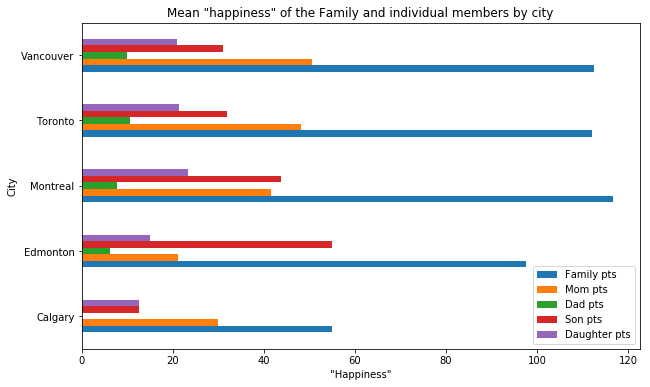

In [63]:
df = data_vis.groupby("City").mean()
df.plot(kind='barh', figsize=(10, 6))
plt.xlabel('"Happiness"')
plt.ylabel('City')
plt.title('Mean "happiness" of the Family and individual members by city')

plt.show()

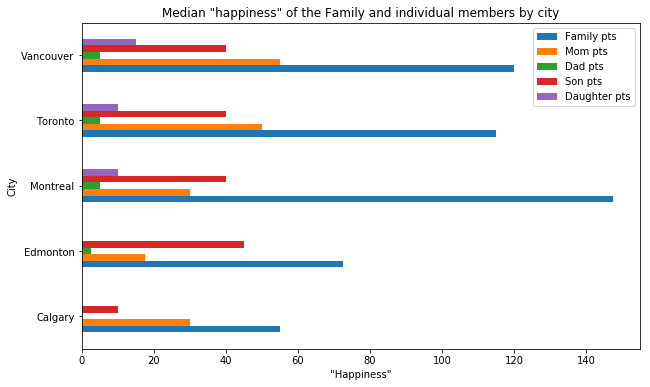

In [64]:
df = data_vis.groupby("City").median()
df.plot(kind='barh', figsize=(10, 6))

plt.xlabel('"Happiness"')
plt.ylabel('City')
plt.title('Median "happiness" of the Family and individual members by city')

plt.show()

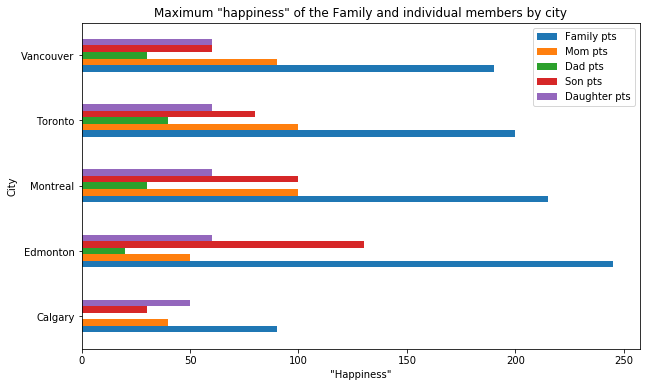

In [65]:
df = data_vis.groupby("City").max()
df.plot(kind='barh', figsize=(10, 6))

plt.xlabel('"Happiness"')
plt.ylabel('City')
plt.title('Maximum "happiness" of the Family and individual members by city')

plt.show()

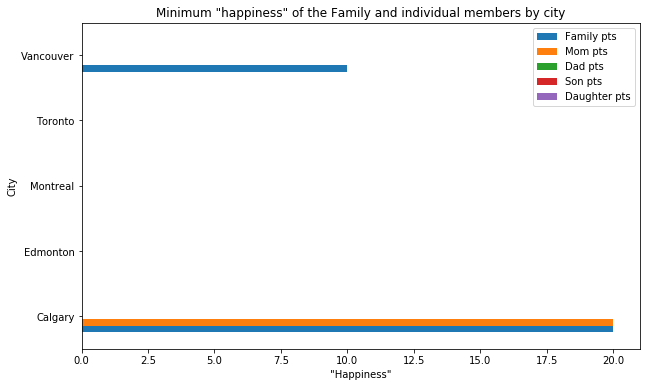

In [66]:
df = data_vis.groupby("City").min()
df.plot(kind='barh', figsize=(10, 6))

plt.xlabel('"Happiness"')
plt.ylabel('City')
plt.title('Minimum "happiness" of the Family and individual members by city')

plt.show()

### Conclusion

In [68]:
print("The optimal neighborhood to find a place to stay, for the hypothetical family, is "+str(Ranking.iloc[0,0]+', ')+"in the city "+ str(Dataset.loc[Dataset["Neighbourhood"]==Ranking.iloc[0,0]].reset_index().loc[0,"City"])+"." \
     +"\nFor a maximized minimum of preferences met, the family should find a place to stay in "+str(Ranking.sort_values(by="Minimum indiv pts", ascending=False).iloc[0,0]+', ')+"in the city "+ str(Dataset.loc[Dataset["Neighbourhood"]==Ranking.sort_values(by="Minimum indiv pts", ascending=False).iloc[0,0]].reset_index().loc[0,"City"])+"." \
     +"\nWith regards to the optimal city, picking a random neighborhood, the highest family median 'happiness', defined as preferences met, is obtained in " +str(data_vis.groupby("City").median().sort_values("Family pts", ascending=False).index[0])+".")

The optimal neighborhood to find a place to stay, for the hypothetical family, is North Downtown, in the city Edmonton.
For a maximized minimum of preferences met, the family should find a place to stay in SW Downtown, in the city Vancouver.
With regards to the optimal city, picking a random neighborhood, the highest family median 'happiness', defined as preferences met, is obtained in Montreal.
